# Assortment Optimization and Newsvendor Problem

## Set-up

In [1]:
import numpy as np
import pandas as pd
from gurobipy import *
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
import sklearn.tree as tree
import graphviz 

## Question 1: Designing a Sushi Menu

### Part 1: Understanding the data

First, let's load our sushi info data and the sushi utility data.

In [2]:
df_info = pd.read_csv('sushi_info.csv', header=None)
df_info = df_info.rename(columns={0: 'name', 1: 'category', 2: 'price'})
sushi_utility = np.genfromtxt('sushi_utilities_mat.csv', delimiter=',')

In [3]:
df_info

,name,category,price
0,ebi,6,14.71
1,anago,3,15.94
2,maguro,1,15.00
3,ika,5,12.12
4,uni,8,26.30
...,...,...,...
95,karei,2,8.00
96,hiramasa,0,8.00
97,namako,8,12.00
98,shishamo,0,8.00


In [9]:
sushi_utility

array([[2.58738227, 1.7350962 , 2.8057844 , ..., 1.36101624, 1.6240616 ,
        1.54830768],
       [1.7297663 , 1.4708043 , 1.46830921, ..., 0.27596015, 0.42032138,
        0.30896378],
       [3.34476731, 3.30225465, 3.84613956, ..., 1.43976384, 1.68563883,
        1.73443892],
       ...,
       [3.36391552, 2.90684874, 3.3925252 , ..., 3.122866  , 2.31925383,
        2.4390661 ],
       [2.85628107, 2.22074824, 2.64534802, ..., 1.08939582, 1.21020218,
        1.35564913],
       [3.91464174, 3.35614098, 3.22951918, ..., 3.23661939, 3.21807821,
        3.10566456]])

Now, let's find the five most preferred sushis for customer 1.

In [10]:
ascending = np.argsort(sushi_utility[0])
descending = ascending[::-1]
five_preferred = descending[0:5]
for i in five_preferred:
    print(df_info.iloc[:,0][i])

negi_toro
ika
maguro
samon
inari


Now, let's find the five least preferred sushis for customer 2.

In [11]:
ascending_2 = np.argsort(sushi_utility[1])
five_least = ascending_2[0:5]
for i in five_least:
    print(df_info.iloc[:,0][i])

karasumi
komochi_konbu
kyabia
awabi
kazunoko


Now, we compute the rank of each of the 100 sushis according to their utilities.

In [41]:
sushi_utility

array([[2.58738227, 1.7350962 , 2.8057844 , ..., 1.36101624, 1.6240616 ,
        1.54830768],
       [1.7297663 , 1.4708043 , 1.46830921, ..., 0.27596015, 0.42032138,
        0.30896378],
       [3.34476731, 3.30225465, 3.84613956, ..., 1.43976384, 1.68563883,
        1.73443892],
       ...,
       [3.36391552, 2.90684874, 3.3925252 , ..., 3.122866  , 2.31925383,
        2.4390661 ],
       [2.85628107, 2.22074824, 2.64534802, ..., 1.08939582, 1.21020218,
        1.35564913],
       [3.91464174, 3.35614098, 3.22951918, ..., 3.23661939, 3.21807821,
        3.10566456]])

In [43]:
# Initialize sushi rank matrix
sushi_rank = np.zeros((500, 100))

# Compute rank of each of 100 sushis according to utilities
for i in range(500):
    array = sushi_utility[i]
    order = np.argsort(array)
    ranks = np.argsort(order)
    sushi_rank[i] = ranks

# Compute average rank over the 500 customers
avg_rank = np.mean(sushi_rank, axis=0)
avg_ascending = np.argsort(avg_rank)
avg_descending = avg_ascending[::-1]

Below are the five with the best average rank over the 500 customers.

In [51]:
five_best = avg_descending[0:5]
for i in five_best:
    print(df_info.iloc[:,0][i])

negi_toro
maguro
kurumaebi
negi_toro_maki
ebi


Below is the five with the worst average rank over the 500 customers.

In [53]:
sushi_worst = avg_ascending[0]
print(df_info.iloc[:,0][sushi_worst])

kyabia


Now we find the sushi that is the most controversial as measured by standard deviation.

In [10]:
sushi_std = np.std(sushi_rank, axis=0)
std_ascending = np.argsort(sushi_std)
std_descending = std_ascending[::-1]
most_controversial = std_descending[0]
print('Most controversial:',df_info.iloc[most_controversial][0])

Most controversial: awabi


### Part 2: Common-sense solutions

Now, let's compute the expected per-customer revenue of an assortment of sushi items S = {1,2,..,100} where each customer picks the option that gives them the highest utility.

First, we build the function that calculates our expected revenue per-customer.

In [11]:
# Get the no-purchase utilities
nopurchase_utilities = np.full((500,), 3)
sushi_utility = np.concatenate( (sushi_utility, nopurchase_utilities[:,None]) , axis = 1)
# Get the prices of sushi
prices = df_info.iloc[:,2].to_numpy()
# Get the number of products and customers
nProducts = 100
nCustomers = 500

# Function to compute expected revenue
# S - the product line, represented as an array of integers
def expected_revenue(S):
    # Add the no-purchase option:
    # NB: the products are numbered from 0 to 99. Index 100 ( = nProducts) will correspond to the no-purchase option. 
    S2 = np.append(S, nProducts)
    
    choice_probabilities = {}
    for i in S2:
        choice_probabilities[i] = 0.0;
    
    for k in range(nCustomers):
        ind = np.argmax(sushi_utility[k,S2])
        choice_probabilities[S2[ind]] += 1.0/nCustomers
        
    exp_revenue = sum([choice_probabilities[i] * prices[i] for i in S])
        
    return exp_revenue, choice_probabilities

Next, we use the above function to find the expected revenue if we offer all products.

In [12]:
S_all = np.array([i for i in range(nProducts)])
exp_revenue_all, choice_probabilities_all = expected_revenue( S_all )
print("Expected revenue (offer all sushi products): ", exp_revenue_all)

Expected revenue (offer all sushi products):  21.509720000000016


Now, suppose we offer only the ten highest revenue sushis. Below are the ten highest revenue sushis.

In [13]:
# Obtain the ten highest revenue sushis
prices_ascending = np.argsort(prices)
prices_descending = prices_ascending[::-1]
ten_highest = prices_descending[0:10]
ten_highest

array([ 8, 14, 47, 12,  4, 79, 19, 46, 20, 41], dtype=int64)

Now, let's find revenue if we offer only these ten sushis.

In [14]:
# Find expected revenue
exp_revenue_ten, choice_probabilities_ten = expected_revenue( ten_highest )
print("Expected revenue (offer ten highest revenue sushis): ", exp_revenue_ten)

Expected revenue (offer ten highest revenue sushis):  25.63944000000002


Now, let's determine for every customer what their most preferred sushi is and find expected revenue if we offer all of the most preferred sushis.

In [15]:
S_mostpref = np.argmax(sushi_utility[:,0:nProducts], axis = 1)

S_mostpref = np.unique(S_mostpref)

exp_revenue_mostpref, choice_probabilities_mostpref = expected_revenue( S_mostpref )
print("Expected revenue (offer most preferred): ", exp_revenue_mostpref)

Expected revenue (offer most preferred):  21.509720000000016


### Part 3: An integer optimization model

Let's implement the linear optimization relaxation version of the model where we relax x and y to be continuous decision variables as opposed to binary decision variables.

In [16]:
m = Model()

# Create the decision variables
x = m.addVars(nProducts, vtype = GRB.BINARY )
y = m.addVars(nCustomers, nProducts+1, vtype = GRB.BINARY)

# Create the constraints:
print("Creating constraints...")
for k in range(nCustomers):
    m.addConstr( sum(y[k,i] for i in range(nProducts+1)) == 1) # (1b)
    for i in range(nProducts):
        m.addConstr( y[k,i] <= x[i] ) # (1c)
        m.addConstr( quicksum( sushi_utility[k,j] * y[k,j] for j in range(nProducts+1)) >= sushi_utility[k,i] * x[i] + sushi_utility[k,nProducts]*(1 - x[i])) # (1d)
    m.addConstr( quicksum( sushi_utility[k,j] * y[k,j] for j in range(nProducts+1)) >= sushi_utility[k,nProducts] ) # (1e)

# Create the objective:
print("Creating objective...")
m.setObjective( quicksum(prices[i] * 1.0/nCustomers * y[k,i] for k in range(nCustomers) for i in range(nProducts)), GRB.MAXIMIZE)

# Update and solve
m.update()

print("Update completed")
m_relaxed = m.relax()

m_relaxed.optimize()

relaxation_bound = m_relaxed.objval

print("Relaxation bound: ", relaxation_bound)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-31
Creating constraints...
Creating objective...
Update completed
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 101000 rows, 50600 columns and 5301000 nonzeros
Model fingerprint: 0x56828d7b
Coefficient statistics:
  Matrix range     [6e-06, 5e+00]
  Objective range  [2e-02, 7e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve time: 1.45s
Presolved: 101000 rows, 50600 columns, 5301000 nonzeros

Ordering time: 0.25s

Barrier performed 0 iterations in 4.38 seconds (3.04 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 1191 iterations and 4.38 seconds (5.87 work units)
Optimal objective  3.058751154e+01
Relaxa

Now, let's implement the integer version of the problem below.

In [17]:
m.optimize()

S_optimal = [i for i in range(nProducts) if x[i].x > 0.5]
print("Optimal set of products: ", S_optimal)

optimal_revenue = m.objval
print("Optimal profit: ",optimal_revenue)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 101000 rows, 50600 columns and 5301000 nonzeros
Model fingerprint: 0x613f8fbb
Variable types: 0 continuous, 50600 integer (50600 binary)
Coefficient statistics:
  Matrix range     [6e-06, 5e+00]
  Objective range  [2e-02, 7e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 72953 rows and 36666 columns (presolve time = 5s) ...
Presolve removed 73442 rows and 36667 columns
Presolve time: 8.10s
Presolved: 27558 rows, 13933 columns, 401275 nonzeros
Variable types: 0 continuous, 13933 integer (13933 binary)
Found heuristic solution: objective 21.5232800

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7270400e+00   6.000000e+01   1.200000e+08      9s
Concurren

Below are the names of the optimal set of sushi products.

In [18]:
for i in S_optimal:
    print(df_info.iloc[:,0][i])

toro
awabi
saba
tarabagani
mentaiko_maki
ika_nattou
tobiuo


## Question 2: Hospital Staffing

### Part 2: Solving the Basic Newsvendor Model

First, let's load our nurse data and then split it into a training set (200 observations) and test set (100 observations).

In [16]:
df_nurse = pd.read_csv('nurse.csv')
X = df_nurse.loc[:, ~df_nurse.columns.isin(['DailyED', 'Day'])]
y = df_nurse.iloc[:,1]

X_train = X.iloc[0:200,:]
X_test = X.iloc[200:300,:].reset_index(drop=True)
y_train = y.iloc[0:200]
y_test = y.iloc[200:300].reset_index(drop=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 5)
(100, 5)
(200,)
(100,)


Before we use the training set and test set, we can find the quantile of the empirical distribution of DailyED as follows.

In [17]:
c_u = 5400 - 2160
c_o = 2160
staffing_quantile = c_u / (c_u + c_o)
print(staffing_quantile)

0.6


Next, we can plot the empirical distribution of DailyED in the training set.

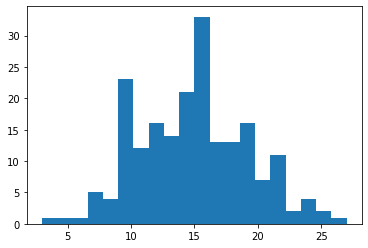

In [18]:
plt.hist(y_train, bins=20)
plt.show()

From the empirical distribution of DailyED, let's determine the optimal staffing level based on our quantile value.

In [19]:
opt_Q = np.quantile(y_train, staffing_quantile)
print("Optimal Q (using NV formula): ", opt_Q)

Optimal Q (using NV formula):  16.0


Now, let's find average costs of the 200 days in the training set that the staffing level would incur based on this optimal staffing level.

In [21]:
# Daily cost calculation function
def staffing_cost(D):
    Q = opt_Q
    cost = 0
    if D>Q:
        cost = (D-Q) * c_u + c_o * D
    else:
        cost = (Q-D) * c_o + c_o * D
    return cost

# Obtain array of costs for each DailyED in training set
cost_train = np.zeros(200)
for D in range(200):
    demand = y_train[D]
    cost_train[D] = staffing_cost(demand)

avg_cost_train = cost_train.mean()
print("Average cost of training set: ", avg_cost_train)

Average cost of training set:  41256.0


In addition, we can do the same with the 100 days in the test set.

In [22]:
cost_test = np.zeros(100)
for D in range(100):
    demand = y_test[D]
    cost_test[D] = staffing_cost(demand)

avg_cost_test = cost_test.mean()
print("Average cost of test set: ", avg_cost_test)

Average cost of test set:  39528.0


### Part 3: Solving the Contextual Newsvendor Model

We will now build a regression tree below to solve the contextual problem.

In [23]:
staffing_tree = tree.DecisionTreeRegressor(max_depth = 2)
staffing_tree = staffing_tree.fit(X_train,y_train)

Now let's plot the tree using `graphviz`.

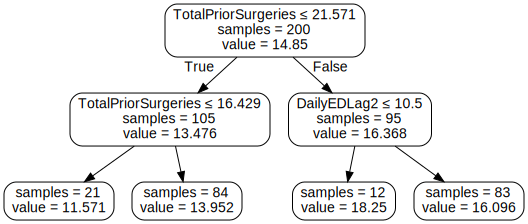

In [24]:
dot_data = tree.export_graphviz(staffing_tree, out_file=None,
                                feature_names=X.columns, impurity = False, 
                                   rounded=True,  
                                  special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("Staffing") 
graph

Now, for each leaf of the tree we can calculate the optimal staffing level by finding the corresponding quantile.

In [25]:
leaf_mapping = staffing_tree.apply(X_train)

leaves = [i for i in range(staffing_tree.tree_.node_count) if staffing_tree.tree_.children_left[i] == -1 ]

leaf_to_quantile = np.zeros( staffing_tree.tree_.node_count )

for ell in leaves:
    ind = leaf_mapping == ell 
    y_ell = y_train[ind]
    leaf_to_quantile[ell] = round(np.quantile(y_ell, staffing_quantile))
    
leaf_to_quantile

array([ 0.,  0., 13., 15.,  0., 18., 17.])

For the training set, let's calculate the average cost that this staffing rule would incur.

In [37]:
train_set_decisions

array([18., 18., 17., 17., 17., 17., 15., 15., 15., 15., 15., 15., 15.,
       17., 18., 17., 17., 17., 17., 17., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 17., 17., 17., 17., 18.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 13., 13., 13., 13.,
       13., 13., 13., 17., 18., 18., 17., 17., 17., 17., 18., 17., 17.,
       17., 17., 17., 17., 15., 15., 15., 15., 15., 15., 15., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 18., 18., 15., 15., 15., 15., 15., 15., 15.,
       18., 17., 17., 17., 17., 17., 17., 13., 13., 13., 13., 13., 13.,
       13., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 13., 13., 13., 13., 13., 13., 13., 15., 15.,
       15., 15., 15., 15., 15., 18., 17., 17., 17., 18., 17., 17

In [38]:
train_set_leaves = staffing_tree.apply(X_train)
train_set_decisions = leaf_to_quantile[train_set_leaves]

train_set_cost = c_u * np.maximum(y_train - train_set_decisions, 0) + c_o * np.maximum(train_set_decisions - y_train, 0) + 2160 * y_train
avg_train_set_cost = train_set_cost.mean(axis = 0)
print("Average contextual training set cost:", avg_train_set_cost)

Average contextual training set cost: 40554.0


For the test set, let's calculate the average cost that this staffing rule would incur.

In [39]:
test_set_leaves = staffing_tree.apply(X_test)
test_set_decisions = leaf_to_quantile[test_set_leaves]

test_set_cost = c_u * np.maximum(y_test - test_set_decisions, 0) + c_o * np.maximum(test_set_decisions- y_test, 0) + 2160 * y_test
avg_test_set_cost = test_set_cost.mean(axis = 0)
print("Average contextual test set cost:", avg_test_set_cost)

Average contextual test set cost: 38772.0
